# Importing libraries

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, classification_report, accuracy_score

from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, GlobalAvgPool1D
from tensorflow import keras

import matplotlib.pyplot as plt


# Reading data

In [ ]:
df_train = pd.read_csv("/content/data_train.csv", index_col=0)
df_test = pd.read_csv("/content/data_test.csv", index_col=0)
print(len(df_train), len(df_test))
df_train.head()

16968 7272


,article_text,headline,is_sarcastic
15897,Oh my gosh. That’s just the sweetest thing eve...,photo of meghan markle's dad could offer a big...,0
8138,“I will fight for equality for transgender peo...,vietnamese singer wins international transgend...,0
21249,"In Pennsylvania, there is Goofy kicking Donald...",it's not as easy as you think to spot a gerrym...,0
16235,"The message ""All Muslims Are Scum"" was daubed ...",mystery painter turns vile anti-muslim graffit...,0
11381,LONDON—Expressing her annoyance after nude pho...,queen elizabeth annoyed nude pictures of princ...,1


In [ ]:
X_train = df_train[['headline', 'article_text']]
Y_train = df_train['is_sarcastic']

X_test = df_test[['headline', 'article_text']]
Y_test = df_test['is_sarcastic']

# Tokenization


Getting GloVe embeddings from [huggingface](https://huggingface.co/stanfordnlp/glove/resolve/main/glove.twitter.27B.zip)

In [ ]:
# Getting GloVe embedddings from https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip
# glove.42B.300d.zip

import requests, zipfile, io
url = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip"
req = requests.get(url) 
z = zipfile.ZipFile(io.BytesIO(req.content))
print(z.namelist())

# Extracting the file 'glove.42B.300d.txt'
z.extract('glove.42B.300d.txt')

embeddings_index = {}
f = open('glove.42B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# sample length of embedding for word "disagree"
print(len(embeddings_index['disagree']))

['glove.42B.300d.txt']
Found 1917495 word vectors.
300


In [ ]:
vocab_size = 1000
oov_token = "<OOV>"
max_length_headline = 50
max_length_article = 150
padding_type = "post"
trunction_type="post"
Tokenizer()
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train.apply(lambda x: x[0] + " " + x[1], axis=1))
word_index = tokenizer.word_index
print(len(word_index.keys()))

93100


# LSTM Classification Model 1

Headlines only

In [ ]:
def get_tokenized_padded_features(text):
    X_headlines = tokenizer.texts_to_sequences(text['headline'])
    X_headlines_padded = pad_sequences(X_headlines,maxlen=max_length_headline, padding=padding_type, 
                        truncating=trunction_type)
    
    return X_headlines_padded

In [ ]:
X_train_padded = get_tokenized_padded_features(X_train)
X_test_padded = get_tokenized_padded_features(X_test)

print(X_train_padded.shape, X_test_padded.shape)

(16968, 50) (7272, 50)


In [ ]:
# build embedding matrix
# Vector length = 300 according to the version of glove embedding used (glove.42B.300d.txt)
vec_length = 300
embedding_matrix = np.zeros((len(word_index) + 1, vec_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            vec_length,
                            weights = [embedding_matrix],
                            input_length = max_length_headline,
                            trainable = False)

In [ ]:
embedding_dim = vec_length
input_length = max_length_headline
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(embedding_dim, return_sequences=True, dropout=0.25, recurrent_dropout=0.1, name='Bidirectional1')),
    Dropout(0.25,name ='Dropout1'),
    Bidirectional(LSTM(embedding_dim, return_sequences=True, dropout=0.25, recurrent_dropout=0.1,name='Bidirectional2')),
    GlobalAvgPool1D(name ='GlobalAvgPool'),
    Dense(9, activation='relu', name ='Dense'),
    Dropout(0.25,name = 'Dropout2'),
    Dense(1, activation='sigmoid', name = 'Dense_output')
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=5*1e-3),loss='binary_crossentropy',metrics=['binary_accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 300)           27930300  
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 600)          1442400   
 nal)                                                            
                                                                 
 Dropout1 (Dropout)          (None, 50, 600)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 50, 600)          2162400   
 nal)                                                            
                                                                 
 GlobalAvgPool (GlobalAverag  (None, 600)              0         
 ePooling1D)                                                     
                                                      

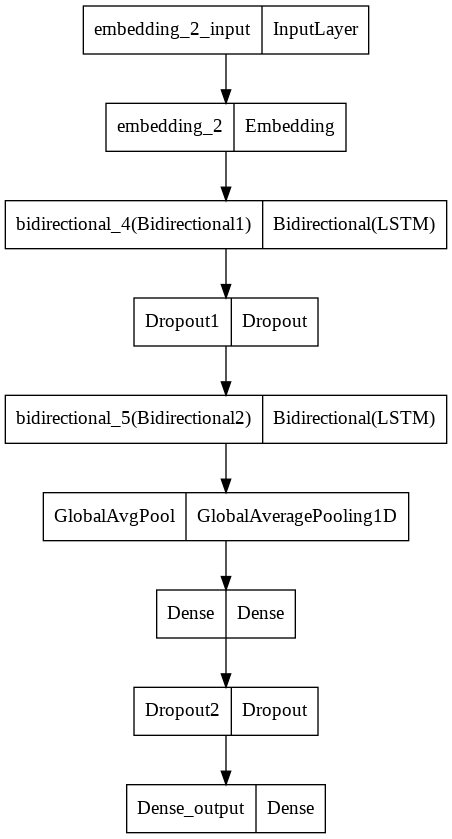

In [ ]:
# model architecture for LSTM
keras.utils.plot_model(model)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss='binary_crossentropy',metrics=['binary_accuracy'])
history_headline = model.fit(X_train_padded, Y_train, epochs=5, validation_data=(X_test_padded, Y_test), batch_size=256)

Epoch 1/5
67/67 [==============================] - 80s 966ms/step - loss: 0.5567 - binary_accuracy: 0.7066 - val_loss: 0.4563 - val_binary_accuracy: 0.7790
Epoch 2/5
67/67 [==============================] - 59s 882ms/step - loss: 0.4600 - binary_accuracy: 0.7815 - val_loss: 0.4123 - val_binary_accuracy: 0.8035
Epoch 3/5
67/67 [==============================] - 58s 871ms/step - loss: 0.4320 - binary_accuracy: 0.7945 - val_loss: 0.3988 - val_binary_accuracy: 0.8097
Epoch 4/5
67/67 [==============================] - 59s 874ms/step - loss: 0.4135 - binary_accuracy: 0.8062 - val_loss: 0.3818 - val_binary_accuracy: 0.8172
Epoch 5/5
67/67 [==============================] - 59s 876ms/step - loss: 0.3959 - binary_accuracy: 0.8179 - val_loss: 0.3924 - val_binary_accuracy: 0.8079


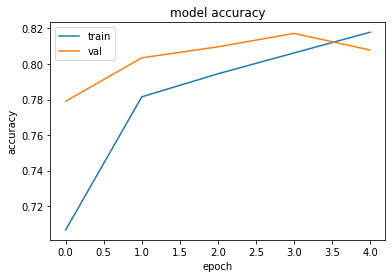

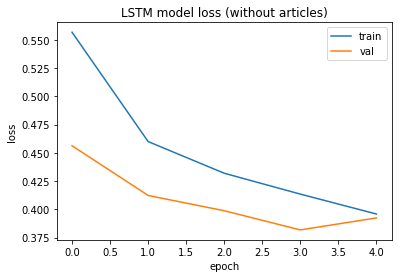

In [ ]:
plt.plot(history_headline.history['binary_accuracy'])
plt.plot(history_headline.history['val_binary_accuracy'])
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_headline.history['loss'])
plt.plot(history_headline.history['val_loss'])
plt.title('LSTM model loss (without articles)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
def evaluate_results(X, Y_true, model):
    Y_pred = model.predict(X)
    print(classification_report(Y_true.to_numpy(), (Y_pred>0.5), digits=4))


In [ ]:
evaluate_results(X_test_padded, Y_test, model)

228/228 [==============================] - 18s 77ms/step
              precision    recall  f1-score   support

           0     0.8953    0.7444    0.8129      4077
           1     0.7316    0.8889    0.8026      3195

    accuracy                         0.8079      7272
   macro avg     0.8134    0.8167    0.8078      7272
weighted avg     0.8234    0.8079    0.8084      7272



In [ ]:
model.save('model_LSTM_1.h5')

# LSTM Classification Model 2

Headline + article_text

In [ ]:
# To Get tokenized features
# headlines are padded to length 50 and article text is limited to length 150
# Resulting tokenized features are of length 200
def get_tokenized_padded_features_with_context(text):
    X_headlines = tokenizer.texts_to_sequences(text['headline'])
    X_headlines_padded = pad_sequences(X_headlines,maxlen=max_length_headline, padding=padding_type, 
                        truncating=trunction_type)

    X_articles = tokenizer.texts_to_sequences(text['article_text'])
    X_articles_padded = pad_sequences(X_articles,maxlen=max_length_article, padding=padding_type, 
                        truncating=trunction_type)

    X_concat = np.concatenate((X_headlines_padded, X_articles_padded), axis=1)

    return X_concat


In [ ]:
X_train_padded = get_tokenized_padded_features_with_context(X_train)
X_test_padded = get_tokenized_padded_features_with_context(X_test)

print(X_train_padded.shape, X_test_padded.shape)

(16968, 200) (7272, 200)


In [ ]:
# build embedding matrix
# Vector length = 300 according to the version of glove embedding used (glove.twitter.27B.100d.txt)
vec_length = 300
embedding_matrix = np.zeros((len(word_index) + 1, vec_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            vec_length,
                            weights = [embedding_matrix],
                            input_length = max_length_headline + max_length_article,
                            trainable = False)

In [ ]:
embedding_dim = vec_length
input_length = max_length_headline + max_length_article
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(embedding_dim, return_sequences=True, dropout=0.25, recurrent_dropout=0.1, name='Bidirectional1')),
    Dropout(0.25,name ='Dropout1'),
    Bidirectional(LSTM(embedding_dim, return_sequences=True, dropout=0.25, recurrent_dropout=0.1,name='Bidirectional2')),
    GlobalAvgPool1D(name ='GlobalAvgPool'),
    Dense(9, activation='relu', name ='Dense'),
    Dropout(0.25,name = 'Dropout2'),
    Dense(1, activation='sigmoid', name = 'Dense_output')
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=5*1e-3),loss='binary_crossentropy',metrics=['binary_accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 300)          27930300  
                                                                 
 bidirectional_2 (Bidirectio  (None, 200, 600)         1442400   
 nal)                                                            
                                                                 
 Dropout1 (Dropout)          (None, 200, 600)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 200, 600)         2162400   
 nal)                                                            
                                                                 
 GlobalAvgPool (GlobalAverag  (None, 600)              0         
 ePooling1D)                                                     
                                                      

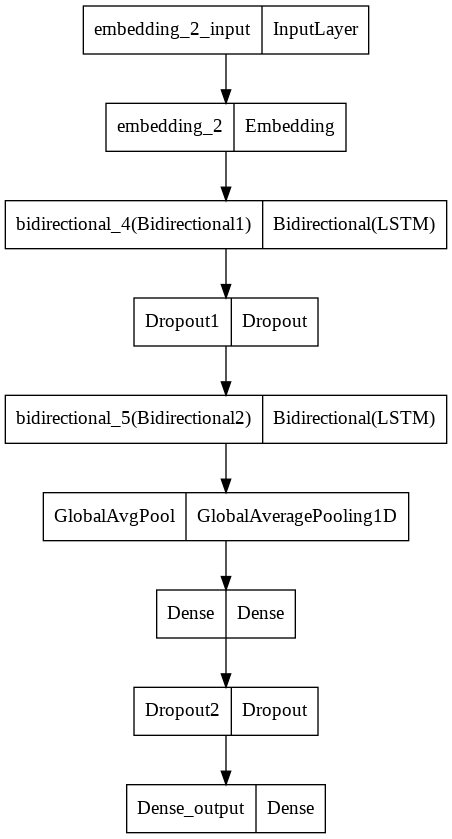

In [ ]:
# model architecture for LSTM
keras.utils.plot_model(model)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss='binary_crossentropy',metrics=['binary_accuracy'])
history = model.fit(X_train_padded, Y_train, epochs=5, validation_data=(X_test_padded, Y_test), batch_size=256)

Epoch 1/5
67/67 [==============================] - 252s 4s/step - loss: 0.5746 - binary_accuracy: 0.7130 - val_loss: 0.3683 - val_binary_accuracy: 0.8526
Epoch 2/5
67/67 [==============================] - 246s 4s/step - loss: 0.3559 - binary_accuracy: 0.8634 - val_loss: 0.2292 - val_binary_accuracy: 0.9098
Epoch 3/5
67/67 [==============================] - 235s 3s/step - loss: 0.2080 - binary_accuracy: 0.9327 - val_loss: 0.1222 - val_binary_accuracy: 0.9554
Epoch 4/5
67/67 [==============================] - 232s 3s/step - loss: 0.1570 - binary_accuracy: 0.9523 - val_loss: 0.1130 - val_binary_accuracy: 0.9587
Epoch 5/5
67/67 [==============================] - 232s 3s/step - loss: 0.1292 - binary_accuracy: 0.9638 - val_loss: 0.1099 - val_binary_accuracy: 0.9611


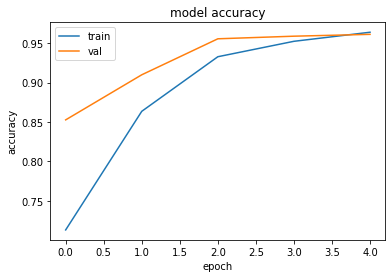

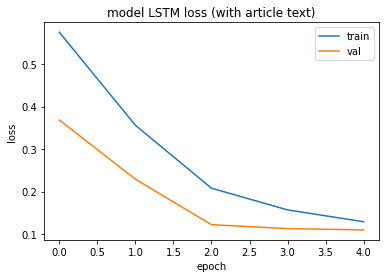

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model LSTM loss (with article text)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
def evaluate_results(X, Y_true, model):
    Y_pred = model.predict(X)
    print(classification_report(Y_true.to_numpy(), (Y_pred>0.5), digits=4))


In [ ]:
evaluate_results(X_test_padded, Y_test, model)

228/228 [==============================] - 66s 291ms/step
              precision    recall  f1-score   support

           0     0.9832    0.9468    0.9646      4077
           1     0.9351    0.9793    0.9567      3195

    accuracy                         0.9611      7272
   macro avg     0.9592    0.9631    0.9607      7272
weighted avg     0.9621    0.9611    0.9612      7272



## Plot Training Loss

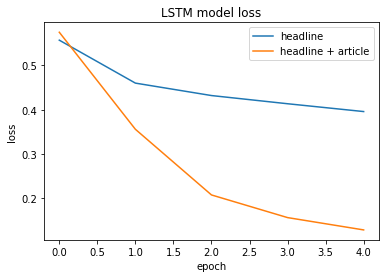

In [ ]:
plt.plot(history_headline.history['loss'])
plt.plot(history.history['loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['headline', 'headline + article'], loc='upper right')
plt.show()